# Linear Regression on Housing Data
In the first lab assignment, you played with Boston Housing Dataset. In this lab assignment, you are going to implement a linear regression model trained on Boston Housing Data by using Knet for the first time. We will take advantage of iterators, callable objects and automatic differentation mechanism.

In [1]:
# Do not touch this cell
# Necessary imports
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick","ArgParse","CUDA"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet
using Statistics
using Random
using Test
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Pkg\src\Pkg.jl:554


## Data Reading
You do not need to worry about data reading and preprocessing: We are going to take advantage of housing data reader which is also a part of Knet. We include some source file and then use ```housing``` function. ```housing``` function takes one input argument: the percentage of the test set to split dataset into two parts. Just take a look at the cell below. In this lab session, we are going to use 20% of the data as test split.

In [2]:
# Do not touch this cell
# Load data
include(joinpath(Knet.dir(), "examples", "housing-linreg", "housing.jl"))
Knet.seed!(1)
xtrn, ytrn, xtst, ytst = Housing.housing(0.20; url="https://raw.githubusercontent.com/ilkerkesen/ufldl-tutorial/master/ex1/housing.data");

# Print size of data matrices for testing
size(xtrn), size(ytrn), size(xtst), size(ytst)

┌ Warning: Knet.seed!() is deprecated, please use Random.seed!() and/or CUDA.seed!() instead
└ @ Knet.KnetArrays C:\Users\volkan\.julia\packages\Knet\rgT4R\src\knetarrays\random.jl:14


((13, 405), (1, 405), (13, 101), (1, 101))

## Minibatching via Iterators
In this part, you are going implement a minibatching procedure (or let's call it pipeline). Remember, you need to implement your own minibatch function, it's forbidden to use Knet's ```minibatch``` procedure. Also, your minibatching scheme must use iterators. Just take a look at [this blog post](https://julialang.org/blog/2018/07/iterators-in-julia-0.7). To implement your minibatching pipeline, we provide you ```HousingData``` struct definition. Different from the original implementation, you are not going to discard the last remaining smaller minibatch, you will use all the instances. Also, remember that, ```HousingData``` structure is not mutable which means you are not able to change the values inside struct.

### Define `HousingData` Struct

In [3]:
"""
    HousingData(x, y; batchsize::Int=100, shuffle::Bool=false)

Create a HousingData object, where `x` is feature matrix, `y` is price array,
`batchsize` is number of instances in a minibatch and `shuffle` indicates
shuffling the order of the instances before the whole iteration process.
"""
struct HousingData
    x
    y
    batchsize::Int
    shuffle::Bool
    num_instances::Int

    function HousingData(
        x, y; batchsize::Int=100, shuffle::Bool=false, dtype::Type=Array{Float64})
        n = size(y,2)
        new(dtype(x), dtype(y), batchsize > n ? n : batchsize, shuffle, n)    
    end
end

# tests for ```HousingData(x, y; ...)```
Knet.seed!(2)
x1 = randn(5, 100); y1 = rand(1, 100)
obj1 = HousingData(x1, y1; batchsize=20, dtype=Array{Float32}, shuffle=true)
@test obj1.shuffle == true
@test typeof(obj1.x) <: Array{Float32}
@test typeof(obj1.y) <: Array{Float32}
@test obj1.batchsize == 20
@test obj1.num_instances == 100
@test sum(abs2.(obj1.x - x1)) < 1e-6
@test sum(abs2.(obj1.y - y1)) < 1e-6
@info "constructor tests passed"

┌ Info: constructor tests passed
└ @ Main In[3]:33


### Implement `length` procedure.
Hint: You can use divrem function. Type ?divrem to see how to use.

In [4]:
"""
    length(d::HousingData)

Return how many minibatches dataset `d` has.
"""
function length(d::HousingData)
    return divrem(d.num_instances, d.batchsize)[2] == 0 ? divrem(d.num_instances, d.batchsize)[1] : divrem(d.num_instances, d.batchsize)[1] + 1
end

# tests for ```length(d::HousingData)```
Knet.seed!(3)
x1 = randn(5, 100); y1 = rand(1, 100)
test_helper1(batchsize) = HousingData(x1,y1; batchsize=batchsize)
objects = [test_helper1(batchsize) for batchsize in (20, 30, 50, 100, 101)]
@test map(length, objects) == [5, 4, 2, 1, 1]
@info "length tests passed"

┌ Info: length tests passed
└ @ Main In[4]:16


### Implement `iterate` Procedure for `HousingData`
In this section, you'll finish your own iterator implementation by defining
`iterate` procedure for `HousingData` objects.

In [5]:
"""
    iterate(d::HousingData[, state])

Iterate over `d::HousingData` object. If `state` is missing, it's the beginning
of the whole iteration process.
"""
function iterate(d::HousingData, state=ifelse(
    d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    rem_idx = size(state, 1)
    
    if rem_idx > d.batchsize
        mb_x = d.x[:, state[1:d.batchsize]]
        mb_y = d.y[:, state[1:d.batchsize]]
        return ((mb_x, mb_y), state[d.batchsize+1:end])
        
    elseif rem_idx == 0
        return nothing
        
    else
        new_bs = rem_idx
        mb_x = d.x[:, state[1:new_bs]]
        mb_y = d.y[:, state[1:new_bs]]
        return ((mb_x, mb_y), [])
    end
end

Knet.seed!(4)
dtrn = HousingData(xtrn, ytrn; shuffle=true)
dtst = HousingData(xtst, ytst)

# Tests for ```iterate``` function
x1 = randn(5, 100); y1 = rand(1, 100);
test_helper2(batchsize) = HousingData(x1,y1; batchsize=batchsize)
test_helper3(batches) = mapreduce(bi->size(bi[2],2), +, batches)
objects = [test_helper1(batchsize) for batchsize in (20, 30, 50, 100, 101)]
data_arrays = map(collect, objects)
num_instances = map(test_helper3, data_arrays)
@test map(length, data_arrays) == map(length, objects)
@test prod(num_instances .== 100) == 1
@info "iterate tests passed"

┌ Info: iterate tests passed
└ @ Main In[5]:40


## Model Implementation via Callable Objects
Next, we are going to implement our model via callable objects. In Julia, we can call objects. Just give a glimpse at the following code snippet:

In [6]:
struct Hello
    planet
    Hello(planet="World") = new(planet)
end

(obj::Hello)() = println("Hello, $(obj.planet)!")

hello_world = Hello()
hello_world()

hello_jupiter = Hello("Jupiter")
hello_jupiter()

Hello, World!
Hello, Jupiter!


For this assingment, you just need to define a linear layer and that's all! Write your solutions to the below cell. Hint: You need to use ```Param``` method of AutoGrad. Just type ```@doc Param``` to see the documentation.

In [7]:
"""
    Linear(inputsize, outputsize; atype=Array{Float64}, scale::Float64=0.1)

Create a linear layer with its weight and bias. Initial weight parameters are
sampled from normal distribution scaled by a `scale` factor. Initial bias
values are zeros.

# Examples
```julia-repl
julia> layer = Linear(5,1);

julia> x = rand(2,5);

julia> layer(x); # forward call
```
"""
struct Linear
    w
    b

    function Linear(inputsize::Int, outputsize::Int,
                    atype=Array{Float64}, scale::Float64=0.1)
        new( Param(randn(outputsize, inputsize) * scale), Param(zeros(outputsize, 1)))
    end
end

function (l::Linear)(x)
    return l.w * x .+ l.b
end

model = Linear(13, 1)


# Tests for ```Linear```
Knet.seed!(5)
test_model = Linear(5,3)
test_data = rand(5,10)
@test fieldnames(Linear) == (:w, :b)
@test typeof(test_model.w) <: Param
@test typeof(test_model.b) <: Param
@test size(test_model.w) == (3,5)
@test size(test_model.b) == (3,1)
@test sum(abs2.(test_model.b.value)) ≈ 0.0
@test size(test_model(test_data)) == (3,10)
@info "Linear tests passed"

┌ Info: Linear tests passed
└ @ Main In[7]:45


## Define Loss Function
In this part, we'll define our loss function. We are going to use minimum squared error loss function,

![MSE](http://web.itu.edu.tr/keseni/mse.png)

We're going to define three diffent functions for this purpose,

1. A function takes predictions and target values as input.
2. A callable object procedure that takes input/output pair as input
3. A callable object procedure that takes our dataset object as input

See function prototypes below and the documentation of ```train!``` function.

In [8]:
"""
    mse(predicted, target)

Calculates minimum squared error (MSE) between predicted and target values.
"""
function mse(predictions, targets)
    N = size(targets, 2)
    return sum((predictions .- targets) .^ 2) ./ (2 * N) 
end


"""
    (m::Linear)(x, y)

Calculate MSE for a single minibatch by using a `Linear` layer / model.
"""
function (m::Linear)(x, y)
    predictions = m(x)
    return mse(predictions, y)
end


"""
    (m::Linear)(data::HousingData)

Calculate MSE for the whole dataset by using a `Linear` layer / model.
"""
function (m::Linear)(data::HousingData)
    mses = [m(x,y) for (x,y) in data]
    return mean(mses)
end



# Tests for `mse`
Knet.seed!(6)
x1 = randn(5, 100); y1 = rand(1, 100); batchsize = 20
test_data = HousingData(x1,y1; batchsize=batchsize, shuffle=false)
test_model = Linear(5, 1)
bx, by = first(test_data)
batch_mse, data_mse = mse(test_model(bx), by), test_model(test_data)
data_mse = test_model(test_data)
@test batch_mse ≈ 0.17215155 || batch_mse ≈ 0.219498036
@test data_mse ≈ 0.21266383 || data_mse ≈ 0.215281964
@info "mse tests passed"

┌ Info: mse tests passed
└ @ Main In[8]:45


## Training with Modular Interface and Iterators
Now, let's implement a ```mytrain!``` procedure to train our network! It takes model, train data, test data, report period (in iterations) and number of maximum iterations. It trains our model until a certain maximum iterations number, records loss values of train and test data splits after each report period. It should output three lists: iterations numbers, loss values of train set, loss values of test set.

Hint: You may need ```sgd!```, ```cycle```, ```take``` and other similar procedures. Use default parameters for ```sgd!```.

┌ Info: mytrain! tests passed
└ @ Main In[9]:35


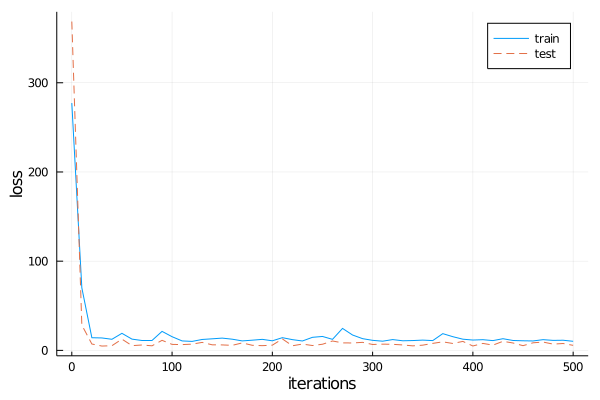

In [9]:
"""
    mytrain!(model::Linear, train_data::HousingData, test_data::HousingData, period=10, iters=500)

Train `model` on `train_data` for `iters` iterations. Calculate losses for the
whole train and test data splits (`train_data` and `test_data`) in every `period`
iteration. Return iteration numbers and losses for train and test data.
"""
function mytrain!(model::Linear, train_data::HousingData, test_data::HousingData,
                  period::Int=10, iters::Int=500)
    train_loss = Array{Float64, 1}()
    test_loss = Array{Float64, 1}()
    
    #push!(train_loss, model(train_data))
    #push!(test_loss, model(test_data))
    
    for _ in 0:period:iters
        
        push!(train_loss, model(train_data))
        push!(test_loss, model(test_data))
        sgd!(model,take(cycle(train_data),period))
        
    end
    return 0:period:iters, train_loss, test_loss
end


# Finally, let's train a network,
Knet.seed!(7)
model = Linear(13, 1)
dtrn = HousingData(xtrn, ytrn; shuffle=true)
dtst = HousingData(xtst, ytst)
iters, trnloss, tstloss = mytrain!(model, dtrn, dtst)
@test trnloss[2] ≈ 70.1396520
@test tstloss[2] ≈ 28.3967556
@info "mytrain! tests passed"
plot(iters, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(iters, tstloss, label="test")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*